# Problem Statement

AN E-Commerce company needs to identify which website visitors are likely to convert into paying customers and predict their potential purchace value to optimuze marketing spend and inventory management.

### Specific Issues:
- Unable to differentiate between browsers and buyers
- Cannot predict revenue from individual customers
- Inefficient allocation of promotional offers
- Lack of data-driven decision making

### Goal:
- Develop predictive models using historical customer data to enable targeted marketing and accurate sales forecasting

In [35]:
#useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, mean_squared_error, 
                             mean_absolute_error, r2_score)
from sklearn.linear_model import LinearRegression, LogisticRegression


sns.set_style('whitegrid')
plt.rcParams['figure.figsize']= (12,6)

In [7]:
df= pd.read_csv('test.csv')
df.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN


## Data Preprocessing and Visualization

In [9]:
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Rows: 233599
Columns: 11


- Create synthetic Purchase_Amount based on patterns. Higher category products = higher price.
- Also create Purchase_Made (binary) based on probability

In [13]:
df['Purchase_Amount'] = (df['Product_Category_1'] * 500 + np.random.normal(2000, 500, len(df))).clip(100, 10000)

purchase_prob= (df['Purchase_Amount']-df['Purchase_Amount'].min()) / (df['Purchase_Amount'].max() - df['Purchase_Amount'].min())

df['Purchase_Made']= (purchase_prob>0.5).astype(int)

print(f"Purchase Made: {df['Purchase_Made'].value_counts().to_dict()}")
print(f"Purchase_Amount: Min=${df['Purchase_Amount'].min():.2f}, Max=${df['Purchase_Amount'].max():.2f}")

Purchase Made: {0: 153749, 1: 79850}
Purchase_Amount: Min=$453.38, Max=$10000.00


#### Handle missing values

In [15]:
df['Product_Category_2']= df['Product_Category_2'].fillna(0,inplace=True)
df['Product_Category_3']= df['Product_Category_3'].fillna(0,inplace=True)

#### Encoding

In [21]:
le_gender= LabelEncoder()
le_age= LabelEncoder()
le_city= LabelEncoder()
le_stay= LabelEncoder()

df['Gender_Encoded']= le_gender.fit_transform(df['Gender'])
df['Age_Encoded']= le_gender.fit_transform(df['Age'])
df['City_Encoded']= le_gender.fit_transform(df['City_Category'])
df['Stay_Encoded']= le_gender.fit_transform(df['Stay_In_Current_City_Years'])

## Exploratory Data Analysis

In [22]:
df_sample = df.sample(n=min(5000, len(df)), random_state=42)

#### Purchase amaount distribution

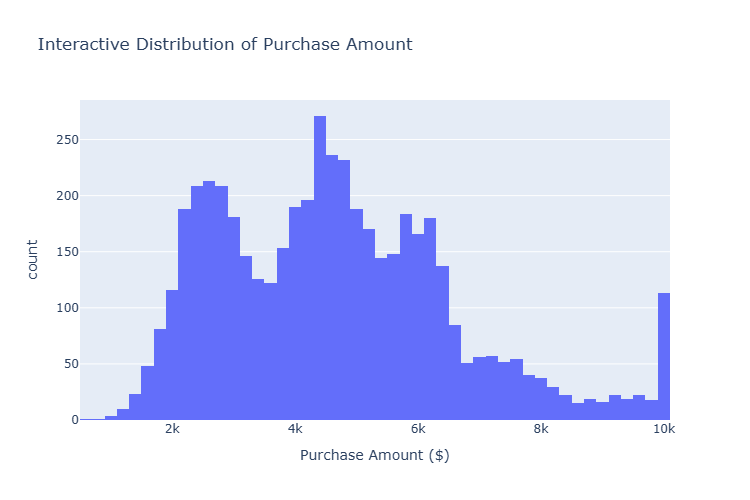

In [23]:
fig = px.histogram(df_sample, x='Purchase_Amount', nbins=50, 
                   title='Interactive Distribution of Purchase Amount',
                   labels={'Purchase_Amount': 'Purchase Amount ($)'},
                   color_discrete_sequence=['#636EFA'])
fig.update_layout(showlegend=False, height=500)

#### Purchase Amount by Gender and Age

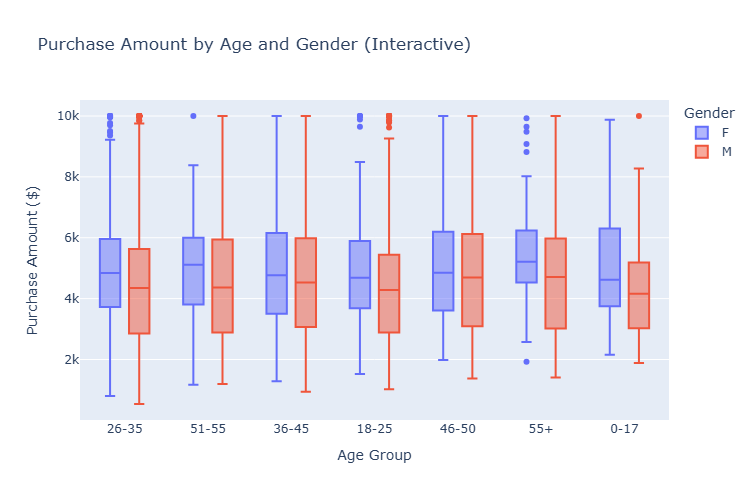

In [24]:
fig = px.box(df_sample, x='Age', y='Purchase_Amount', color='Gender',
             title='Purchase Amount by Age and Gender (Interactive)',
             labels={'Purchase_Amount': 'Purchase Amount ($)', 'Age': 'Age Group'})
fig.update_layout(height=500)

#### scatter plot

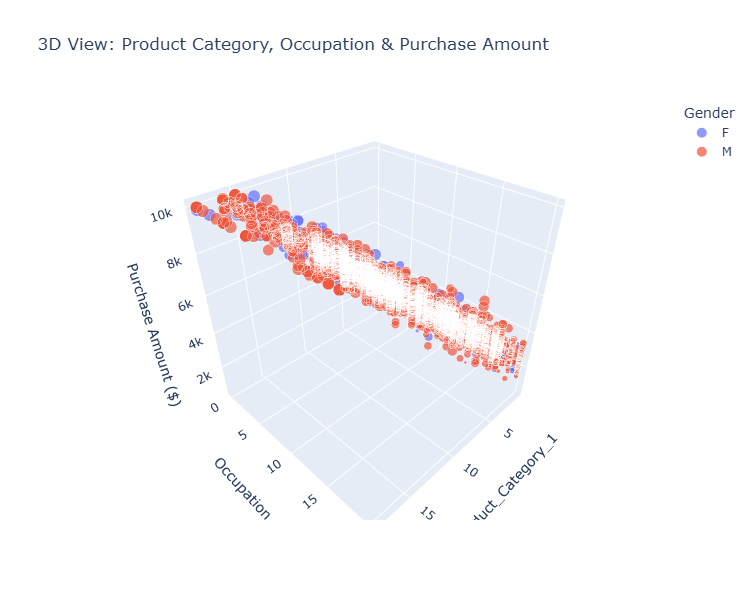

In [25]:
fig = px.scatter_3d(df_sample, x='Product_Category_1', y='Occupation', z='Purchase_Amount',
                     color='Gender', size='Purchase_Amount',
                     title='3D View: Product Category, Occupation & Purchase Amount',
                     labels={'Purchase_Amount': 'Purchase Amount ($)'})
fig.update_layout(height=600)

## Preparing data for modeling

In [30]:
feature_cols= ['Gender_Encoded', 'Age_Encoded', 'Occupation','City_Encoded', 
               'Stay_Encoded', 'Marital_Status','Product_Category_1', 'Product_Category_2', 
               'Product_Category_3']

X= df[feature_cols]
y_classification= df['Purchase_Made']
y_regression= df['Purchase_Amount']

X_train,X_test,y_classTrain,y_classTest, y_regTrain,y_regTest= train_test_split(X,y_classification,y_regression,test_size=0.2,random_state=42)

scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

## Logistic Model

In [37]:
log_model= LogisticRegression(max_iter=1000,random_state=42)
log_model.fit(X_train_scaled,y_classTrain)

y_classPred= log_model.predict(X_test_scaled)
y_classPred_proba= log_model.predict_proba(X_test_scaled)[:,1]

print(f"Accuracy: {accuracy_score(y_classTest,y_classPred)*100:.4f} %")
print(f"Precision: {precision_score(y_classTest,y_classPred):.4f}")
print(f"Recall: {recall_score(y_classTest,y_classPred):.4f}")
print(f"F1-Score: {f1_score(y_classTest,y_classPred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_classTest,y_classPred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_classTest, y_classPred, target_names=['No Purchase', 'Purchase']))

Accuracy: 95.3810 %
Precision: 0.9580
Recall: 0.9047
F1-Score: 0.9306
ROC-AUC: 0.9776

Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.95      0.98      0.97     30735
    Purchase       0.96      0.90      0.93     15985

    accuracy                           0.95     46720
   macro avg       0.95      0.94      0.95     46720
weighted avg       0.95      0.95      0.95     46720



#### Confusion matrix

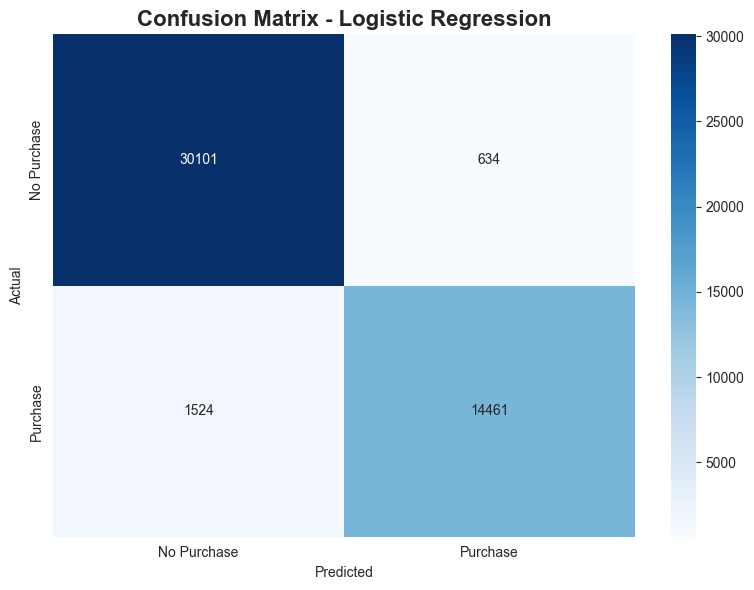

In [39]:
cm = confusion_matrix(y_classTest, y_classPred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=16, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()

#### ROC Curve

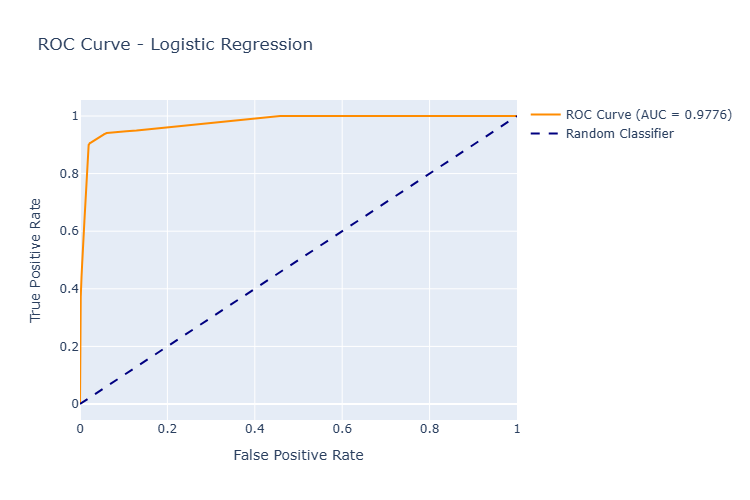

In [41]:
fpr, tpr, thresholds = roc_curve(y_classTest, y_classPred_proba)
roc_auc = roc_auc_score(y_classTest, y_classPred_proba)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {roc_auc:.4f})',
                         line=dict(color='darkorange', width=2)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier',
                         line=dict(color='navy', width=2, dash='dash')))
fig.update_layout(title='ROC Curve - Logistic Regression',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  height=500)


Feature Importance (Top 5):
              Feature  Coefficient
6  Product_Category_1     6.626909
0      Gender_Encoded     0.033058
4        Stay_Encoded     0.013978
1         Age_Encoded    -0.012090
5      Marital_Status     0.011026


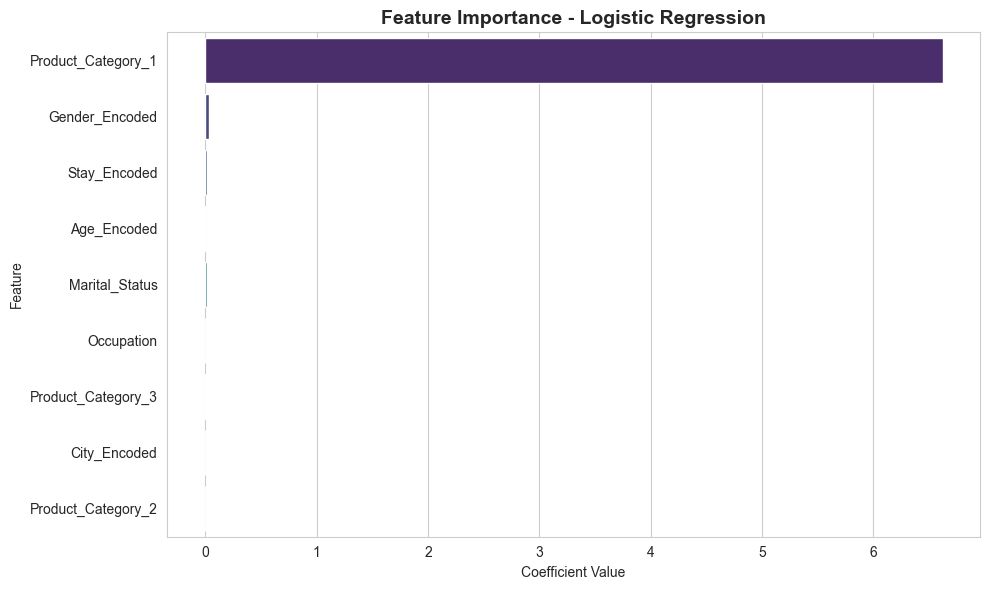

In [45]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Top 5):")
print(feature_importance.head())

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance - Logistic Regression', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.tight_layout()

## Linear Regression

In [49]:
l_model= LinearRegression()
l_model.fit(X_train_scaled,y_regTrain)

y_regPred= l_model.predict(X_test_scaled)

print("\nLINEAR REGRESSION RESULTS:")
print()
print(f"R² Score:  {r2_score(y_regTest, y_regPred) * 100:.4f} %")
print(f"RMSE:      ${np.sqrt(mean_squared_error(y_regTest, y_regPred)):.2f}")
print(f"MAE:       ${mean_absolute_error(y_regTest, y_regPred):.2f}")


LINEAR REGRESSION RESULTS:

R² Score:  93.1053 %
RMSE:      $499.83
MAE:       $397.99


In [52]:
results_df = pd.DataFrame({
    'Actual': y_regTest.values[:1000],  # Plot first 1000 for clarity
    'Predicted': y_regPred[:1000]
})

#### Plots

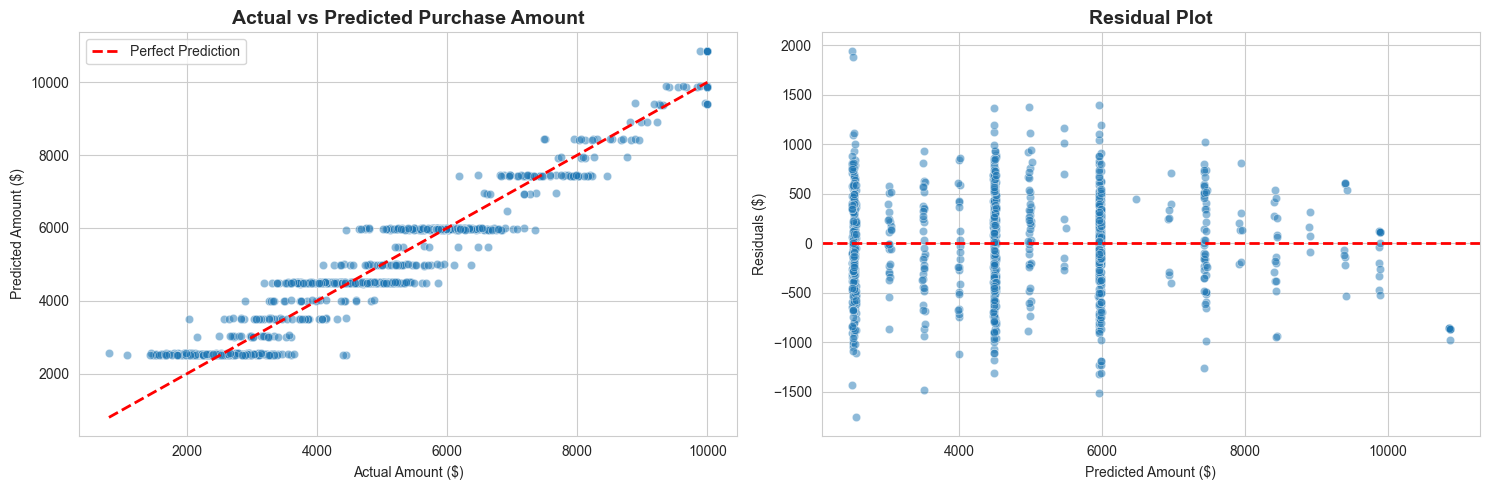

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Scatter plot
sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.5, ax=axes[0])
axes[0].plot([results_df['Actual'].min(), results_df['Actual'].max()],
             [results_df['Actual'].min(), results_df['Actual'].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_title('Actual vs Predicted Purchase Amount', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Amount ($)')
axes[0].set_ylabel('Predicted Amount ($)')
axes[0].legend()

#Residual Plot
residuals = results_df['Actual'] - results_df['Predicted']
sns.scatterplot(x=results_df['Predicted'], y=residuals, alpha=0.5, ax=axes[1])
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Amount ($)')
axes[1].set_ylabel('Residuals ($)')

plt.tight_layout()

#### Actual vs Predicted

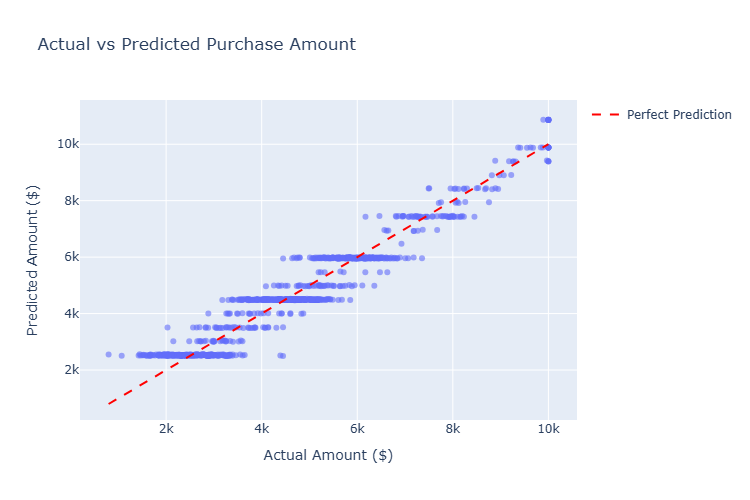

In [56]:
fig = px.scatter(results_df, x='Actual', y='Predicted', 
                 title='Actual vs Predicted Purchase Amount',
                 labels={'Actual': 'Actual Amount ($)', 'Predicted': 'Predicted Amount ($)'},
                 opacity=0.6)
fig.add_trace(go.Scatter(x=[results_df['Actual'].min(), results_df['Actual'].max()],
                         y=[results_df['Actual'].min(), results_df['Actual'].max()],
                         mode='lines', name='Perfect Prediction',
                         line=dict(color='red', dash='dash')))
fig.update_layout(height=500)

#### Feature coefficient


Feature Coefficients (Top 5):
              Feature  Coefficient
6  Product_Category_1  1831.869136
7  Product_Category_2    10.863501
8  Product_Category_3    -9.125116
5      Marital_Status     2.811710
1         Age_Encoded    -1.980511


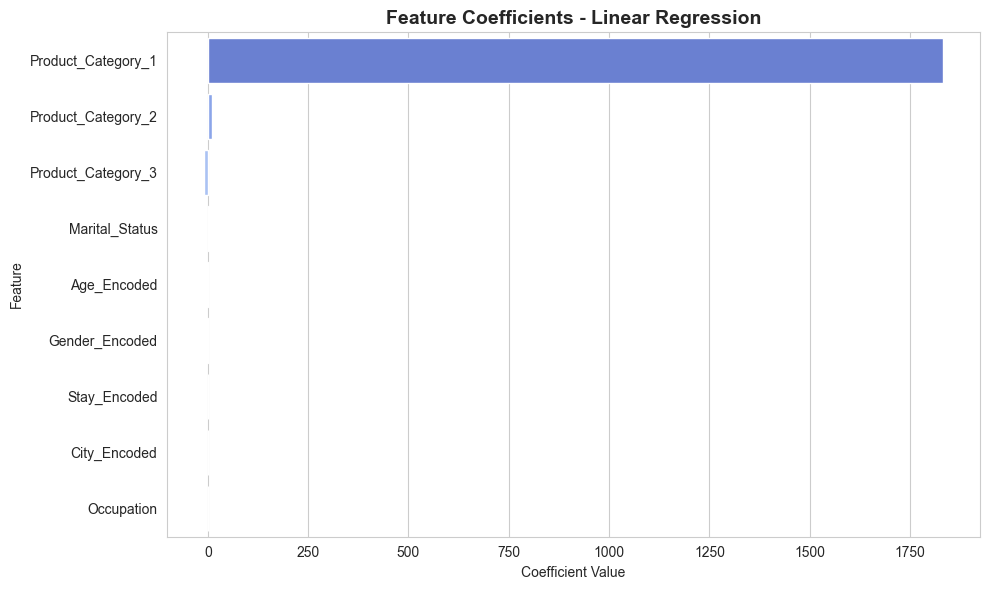

In [59]:
feature_coef = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': l_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients (Top 5):")
print(feature_coef.head())

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_coef, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Feature Coefficients - Linear Regression', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.tight_layout()

## Model Comparision


               Model           Task    Primary Metric Secondary Metric
Logistic Regression Classification 0.9538 (Accuracy) 0.9776 (ROC-AUC)
  Linear Regression     Regression       0.9311 (R²)   $499.83 (RMSE)


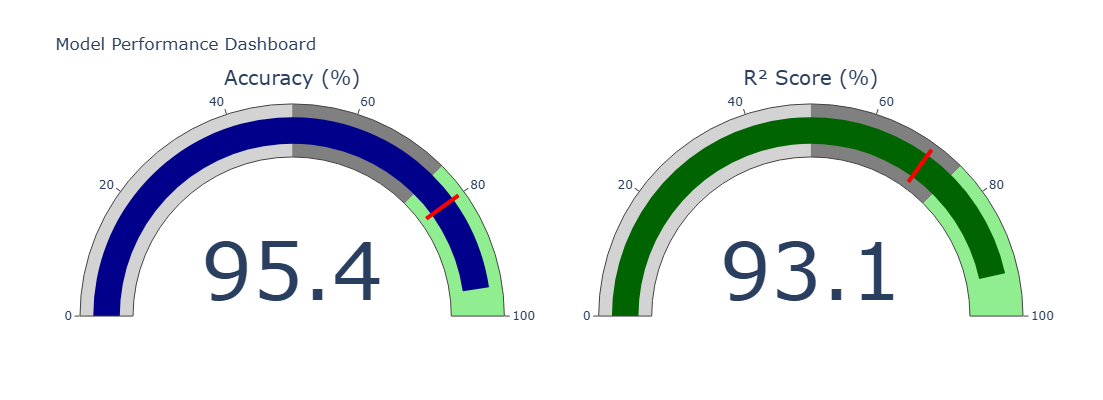

In [63]:
comparison_data = {
    'Model': ['Logistic Regression', 'Linear Regression'],
    'Task': ['Classification', 'Regression'],
    'Primary Metric': [f"{accuracy_score(y_classTest, y_classPred):.4f} (Accuracy)", 
                       f"{r2_score(y_regTest, y_regPred):.4f} (R²)"],
    'Secondary Metric': [f"{roc_auc_score(y_classTest, y_classPred_proba):.4f} (ROC-AUC)",
                         f"${np.sqrt(mean_squared_error(y_regTest, y_regPred)):.2f} (RMSE)"]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Create comparison visualization
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'indicator'}, {'type': 'indicator'}]])

fig.add_trace(go.Indicator(
    mode="gauge+number",
    value=accuracy_score(y_classTest, y_classPred) * 100,
    title={'text': "Accuracy (%)"},
    gauge={'axis': {'range': [0, 100]},
           'bar': {'color': "darkblue"},
           'steps': [{'range': [0, 50], 'color': "lightgray"},
                     {'range': [50, 75], 'color': "gray"},
                     {'range': [75, 100], 'color': "lightgreen"}],
           'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 80}}
), row=1, col=1)

fig.add_trace(go.Indicator(
    mode="gauge+number",
    value=r2_score(y_regTest, y_regPred) * 100,
    title={'text': "R² Score (%)"},
    gauge={'axis': {'range': [0, 100]},
           'bar': {'color': "darkgreen"},
           'steps': [{'range': [0, 50], 'color': "lightgray"},
                     {'range': [50, 75], 'color': "gray"},
                     {'range': [75, 100], 'color': "lightgreen"}],
           'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 70}}
), row=1, col=2)

fig.update_layout(height=400, title_text="Model Performance Dashboard")

## Business Insights

In [62]:
print("\n1. PURCHASE PREDICTION (Logistic Regression):")
print(f"   - Model can predict purchases with {accuracy_score(y_classTest, y_classPred)*100:.1f}% accuracy")
print(f"   - ROC-AUC of {roc_auc_score(y_classTest, y_classPred_proba):.3f} indicates good discrimination")
print(f"   - Top predictive features: {', '.join(feature_importance.head(3)['Feature'].values)}")

print("\n2. SALES FORECASTING (Linear Regression):")
print(f"   - Model explains {r2_score(y_regTest, y_regPred)*100:.1f}% of variance in purchase amount")
print(f"   - Average prediction error: ${mean_absolute_error(y_regTest, y_regPred):.2f}")
print(f"   - Most influential features: {', '.join(feature_coef.head(3)['Feature'].values)}")

print("\n3. RECOMMENDATIONS:")
print("   - Target customers with high purchase probability for marketing campaigns")
print("   - Personalize offers based on predicted purchase amount")
print("   - Focus on high-impact features for better conversion")
print("   - Use predictions for inventory planning and resource allocation")


1. PURCHASE PREDICTION (Logistic Regression):
   - Model can predict purchases with 95.4% accuracy
   - ROC-AUC of 0.978 indicates good discrimination
   - Top predictive features: Product_Category_1, Gender_Encoded, Stay_Encoded

2. SALES FORECASTING (Linear Regression):
   - Model explains 93.1% of variance in purchase amount
   - Average prediction error: $397.99
   - Most influential features: Product_Category_1, Product_Category_2, Product_Category_3

3. RECOMMENDATIONS:
   - Target customers with high purchase probability for marketing campaigns
   - Personalize offers based on predicted purchase amount
   - Focus on high-impact features for better conversion
   - Use predictions for inventory planning and resource allocation
